In [116]:
# Useful libraries

import numpy as np
import matplotlib.pyplot as plt
from collections import deque

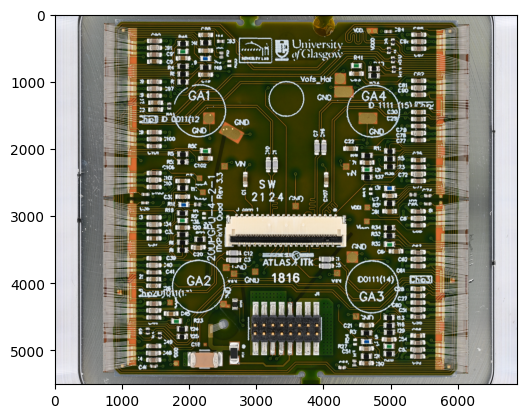

In [117]:
# Loading and plotting the image

img = plt.imread("img_test.jpg")

plt.imshow(img)
plt.show()

In [118]:
# Utils functions for analyzing pixels in general

def norm(pix: np.ndarray) -> float:
    """Computes the norm of an rgb pixel.

    Arguments :
    pix - array of floats : the pixel.

    Returns : float
    """
    return float(pix[0])**2 + float(pix[1])**2 + float(pix[2])**2


def isWhite(img: np.ndarray, coord: tuple, threshold = 90000) -> bool:
    """Tests whether or not a pixel is considered white, using an arbitrary threshold.

    Arguments :

    img - array of pixels : the working image

    coord - tuple of ints : the coordinates of the pixel

    threshold - float : arbitrary threshold

    Returns : bool
    """
    return norm(img[coord[0],coord[1],:]) > threshold


def validCoord(img: np.ndarray, coord: tuple) -> bool:
    """Tests whether or not the coordinates are within the boundaries of the image.

    Arguments :

    img - array of pixels : the working image

    coord - tuple of ints : the coordinates of the working pixel

    Returns : bool
    """
    return 0 <= coord[0] and coord[0] < len(img) and 0 <= coord[1] and coord[1] < len(img[0])


In [119]:
# Intermediate functions for the Breadth-First Search (BFS) wire recognition function

def neighboursList(img: np.ndarray, coord: tuple) -> list:
    """Creates the list of coordinates of the neighbouring white pixels given the current pixel.

    Arguments :

    img - array of pixels : the working image

    coord - tuple of ints : the coordinates of the current pixel

    Returns : list of coordinates
    """
    directions_list = [(1,0),(-1,0),(0,1),(0,-1),(1,1),(1,-1),(-1,1),(-1,-1)]
    neighbours_list = []
    for direction in directions_list:
        neighbour_coord = (coord[0] + direction[0], coord[1] + direction[1])
        if validCoord(img,neighbour_coord) and isWhite(img,neighbour_coord):
            neighbours_list.append(neighbour_coord)
    return neighbours_list


def visit(img: np.ndarray, coord: tuple, wire: list,queue: deque):
    """Visits (i.e. adds to the visiting queue) all the unvisited neighbouring white pixels given the current pixel.

    Arguments :

    img - array of pixels : the working image

    coord - tuple of ints : the coordinates of the current pixel

    wire - list of coordinates : the list of pixels already visited

    queue - deque of coordinates : the visiting queue
    """
    neighbours_list = neighboursList(img,coord)
    for neighbour in neighbours_list:
        if (neighbour not in wire) and (neighbour not in queue):
            queue.append(neighbour)



In [120]:
# Breadth-First Search (BFS) wire recognition function

def bfsWire(img: np.ndarray, start_coord: tuple) -> list:
    """Creates the list of coordinates of all the pixels of a wire given a starting pixel, using a Breadth-First Search (BFS) algorithm.

    Arguments : 

    img - array of pixels : the working image

    start_coord - tuple of ints : the coordinates of the starting pixel

    Returns : list of coordinates
    """
    wire = []
    queue = deque()
    queue.append(start_coord)
    while len(queue) != 0:
        current_coord = queue[0]
        if current_coord not in wire:
            wire.append(current_coord)
        visit(img,current_coord,wire,queue)
        queue.popleft()
    return wire

In [121]:
# Finding the edges coordinates of a given wire

def extremeCoords(wire: list, side = "left") -> int:
    """Finds the index of either the leftmost or the rightmost pixel of a wire, depending on the input side.

    Arguments :

    wire -- list of coordinates : the list of all pixels in the wire

    side -- string : the side chosen for finding the extreme coordinate, by default : left

    Returns : int
    """
    directions = {"left":-1, "right":1}
    index = 0
    for i in range(1,len(wire)):
        if directions[side] * (wire[i][1] - wire[index][1]) < 0:
            index = i
    return index

def wireEdges(wire: list,) -> tuple:
    """Gives the coordinates of both the leftmost and the rightmost pixels of a wire.

    Arguments :

    wire -- list of coordinates : the list of all pixels in the wire

    Returns : tuple of coordinates
    """
    i_left , i_right = extremeCoords(wire, "left"), extremeCoords(wire, "right")
    return (wire[i_left], wire[i_right])

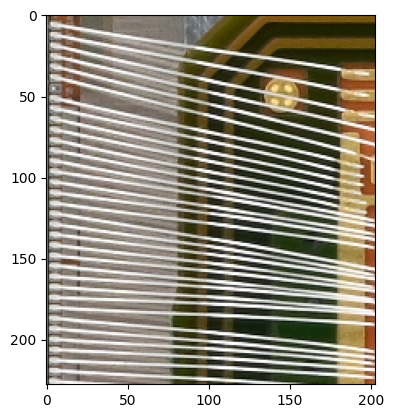

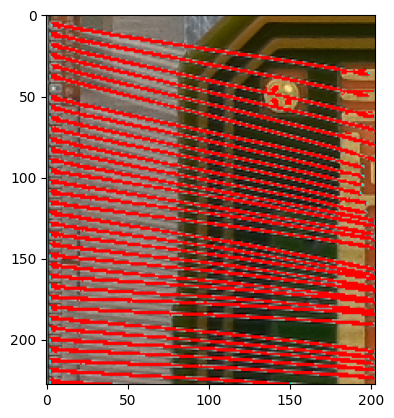

In [122]:
# Testing and plotting the result

test_compressed = img[145:600:2,725:1130:2,:]
plt.imshow(test_compressed)
plt.show()

wires_list = []
concatenacted_list = []
for i in range(len(test_compressed)):
    if isWhite(test_compressed,(i,10)):
        l = bfsWire(test_compressed,(i,10))
        wires_list.append(l)
        concatenacted_list += l

test_copy = test_compressed.copy()

for coord in concatenacted_list:
    test_copy[coord[0],coord[1],:] = np.array([255,0,0])


for wire in wires_list:
    edges = wireEdges(wire)
    test_copy[edges[0][0],edges[0][1],:] = np.array([0,255,255])
    test_copy[edges[1][0],edges[1][1],:] = np.array([0,255,255])

plt.imshow(test_copy)
plt.show()